
<h1 style="font-size":40px>Value at Risk with Merton Jump-Diffusion Model(Portfolio)</h1>


<h2 style = "font-size:25px"><ins>THEORY</ins></h2> 

<p>Much of the mathematics discussed in the previous notebook for a single asset still applies when calculating the Value at Risk for a portfolio. Recall the SDE to model an asset: 
    
$$
d S = \mu S dt + \sigma S dW_t + S(J-1)dN
$$ 

To model a portfolio, we could write 
$$
d S_i = \mu S_i dt + \sigma S_i dW_i + S_i (J_i-1)dN_i
$$ 
instead, where $S_i (i=1,2,3....n)$ represents the price of the $i$th asset. The naïve approach to treat this system would be to solve each equation seperately, assuming that the Brownian and jump terms for each asset are independent random variables. However, asset prices are usually correlated so we need a way to couple the respective random variables if we are to model the portfolio realistically. 

<h3>Correlated Wiener Processes</h3>
To modify the Brownian fluctuations $dW_i$ to account for asset correlations, we first calculate the correlation matrix:

$$
C_{ij} = \text{Cor}(R_i,R_j)
$$

where $R_i$ and $R_j$ represent the returns on the $i$th and $j$th assets respectively. Any matrix $C$ can be decomposed into a product of an lower-triangular matrix and and its conjugate transpose(the so-called Cholesky decomposition):
$$
C = L L^*
$$

Assuming that $C$ is a real matrix, we have

$$
L_{ij} =
\begin{cases}
\sqrt{\Sigma_{ii} - \sum\limits_{k=1}^{j-1} L_{ik}^2}, & \text{if } i = j \\[10pt]
\frac{1}{L_{jj}} \left(\Sigma_{ij} - \sum\limits_{k=1}^{j-1} L_{ik} L_{jk} \right), & \text{if } i > j \\[10pt]
0, & \text{if } i < j
\end{cases}
$$

For a portfolio of $n$ assets, if $d\boldsymbol{W} = (dW_1,dW_2,.....dW_n)$ represents a vector of independent random normal variables, its dot product with $L$ provides a vector of correlated normal variables to model the individual Wiener processes with<a href="#ref1"><sup>[1]</sup></a>. In vector form, we have:

$$
d \boldsymbol{S} = \mu \boldsymbol{S} dt + \sigma \boldsymbol{S} L.d\boldsymbol{W} + \boldsymbol{S} (\boldsymbol{J}-1)d\boldsymbol{N}
$$
This is the standard way to simulate the continuous, fluctuating component of portfolio returns when the underlying assets are assumed to be correlated.
<h3>Correlated Jumps</h3>
There is no standard formalism for correlated jumps terms, but several methods of varying complexity exist. The simplest one consists of jumps perfectly correlated in magnitude and time across all assets. In this notebook, I apply the two-asset method described by Burgess<a href="#ref2"><sup>[2]</sup></a>, wherein each asset contains a term $J_i$ accounting for local shocks as well as a term $J_m$ that accounts for global shocks that affect all assets in the market. Extending this model to multiple assets:

<a id="eq-merton"></a>
$$
\begin{equation}
d \boldsymbol{S} = \mu \boldsymbol{S} dt + \sigma \boldsymbol{S} L.d\boldsymbol{W} + [\boldsymbol{S} [\boldsymbol{J}-1)d\boldsymbol{N} + (J_c-1) dN_c]\tag{1}
\end{equation}
$$
Note that the individual jump terms are constructed from independent random variables, but the common term $(J_c-1) dN_c$ ensures a non-zero correlation amongst asset shocks.


<h2 style= "font-size":30px><ins>CODE</ins></h2>
To implement this model on Python, we first import a few modules. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import seaborn as sns
import multiprocessing as mp

The function below simulates the evolution of asset price for one run, given arrays of $\mu, \sigma, \lambda, \mu_J$ and $\sigma_J$.

In [2]:
def simulate_path(params,seed):
    L,n_assets,S0i,N_days, Δt, μi, σi, λi, μ_Ji, σ_Ji = params
    np.random.seed(seed)                #ensures different random numbers for each run
    s_M = np.zeros((N_days,n_assets))   #stores data for one run
    s_BS = np.zeros((N_days,n_assets))
    s_M[0,:] = S0i
    s_BS[0,:] = S0i 
    
    for j in range(1, N_days):
        dWi = np.dot(L, np.random.normal(0, np.sqrt(Δt), n_assets))
        diffusion = (μi - 0.5 * σi**2) * Δt + σi * dWi
        jumps = np.random.poisson(λi * Δt, n_assets)*np.random.normal(μ_Ji, σ_Ji, n_assets)
        jump_m = np.random.poisson(0.5*np.min(λi) * Δt) * np.random.normal(2*np.max(μ_Ji), np.max(σ_Ji))
        jump = jumps + jump_m
        
        
        s_M[j, :] = s_M[j - 1, :] * np.exp(diffusion + jump)  #vector equation!
        s_BS[j, :] = s_BS[j - 1, :] * np.exp(diffusion)
    
    return s_M,s_BS

The function below calculates the Value at Risk via Monte Carlo simulations for a portfolio of stocks by calling the above function in parallel, using Python's $\texttt{multiprocessing}$ module. Historical returns data is used to obtain the initial stock price, as well as values for the mean $(\mu$) and volatility($\sigma$). These can then plugged into equation <a href="#eq-merton">(1)</a> to calculate the evolution of the stock price as per the Merton jump-diffusion model. The price is sequentially calculated for a time horizon of N_days(days), and the simulation is repeated n_runs times.  The Value at Risk for the portfolio is returned at a given confidence level. 

For the common jump, values are so chosen to obtain a jump that is larger in magnitude but less frequent than any of the individual jumps.

In [3]:
def VaR_Monte_Carlo_P(C,returns,S0i,n_runs,confidence_level):
    Δt = 1/251                          #time step (in years) 
    λ= 0.1                              #reference expected jumps per year
    μ_J = -0.02                         #reference jump size 
    σ_J = 0.05                          #reference jump size volatility
    np.random.seed(0)                   #ensures reproducable results
    n_assets = len(S0i)
    L = np.linalg.cholesky(C)           #Cholesky decomposition
    μi = returns.mean().values          #expected returns
    σi = returns.std().values           #volatilities
    N_days = len(returns)
                
    λi = np.random.uniform(0.5 * λ, 1.5 * λ, n_assets) #create array of λ distributed around reference values
    μ_Ji = np.random.uniform(0.5*μ_J, 1.5*μ_J, n_assets)  
    σ_Ji = np.random.uniform(0.5 * σ_J, 1.5 * σ_J, n_assets)  
    params = L,n_assets,S0i,N_days, Δt, μi, σi, λi, μ_Ji, σ_Ji
    #use multiprocessing to parallelize the simulations
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.starmap(simulate_path,[(params, seed) for seed in range(n_runs)])
    S_M, S_BS = zip(*results)
    S_M = np.array(S_M)  
    S_BS = np.array(S_BS)
    
    R_M = (S_M[:, -1] / S_M[:, 0]) - 1  #final return for each run
    R_BS = (S_BS[:, -1] / S_BS[:, 0]) - 1  
    portfolio_returns_simulated_M = np.dot(np.array(R_M),weights.T)
    portfolio_returns_simulated_BS = np.dot(np.array(R_BS),weights.T)
    
    VaR_Merton = np.percentile(portfolio_returns_simulated_M, 100*(1-confidence_level))
    VaR_BS = np.percentile(portfolio_returns_simulated_BS, 100*(1-confidence_level))
    
    return VaR_Merton,VaR_BS


Once the VaR is calculated, the functions below visualize it against a histogram of the input(historical) data, and plot the correlation matrix for the chosen assets.

In [4]:
def plot_returns(portfolio_returns,confidence_level,varM,varBS):
    fig, ax = plt.subplots(figsize=(10, 6))    
    #histogram of portfolio returns
    sns.histplot(portfolio_returns, bins=50, color="black", alpha=0.6, label="Returns")
    #show VaR
    ax.axvline(varM, color='blue', linestyle='dashed', linewidth=2, label=f'VaR_Merton $({varM:.4f})$')
    ax.axvline(varBS, color='red', linestyle='dashed', linewidth=2, label=f'VaR_Black-Scholes $({varBS:.4f})$')

    ax.set_title(r"Histogram of Historic Portfolio Returns with VaR at ${}\%$ Confidence".format(confidence_level*100))
    ax.set_xlabel("Returns")
    ax.set_ylabel("Frequency")
    ax.legend()
    plt.show()

def plot_corr_mat(C,tickers):
    plt.figure()
    ax = sns.heatmap(C, annot=True, fmt=".3f", cmap="coolwarm", xticklabels=tickers, yticklabels=tickers)
    ax.xaxis.set_ticks_position("top")  
    ax.xaxis.set_label_position("top")
    plt.title("Correlation Matrix",fontsize=15)
    plt.show()

The main function below collects historical data for a list of stocks and constructs a portfolio by weighting them.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


Portfolio VaR at 95.0%(Merton Jump-Diffusion): -3.81%
Portfolio VaR at 95.0%(Black-Scholes): -2.41%


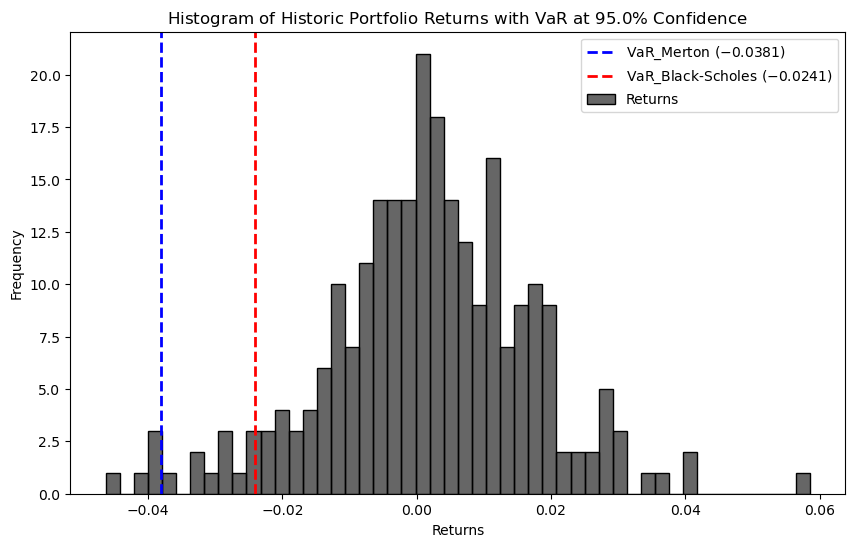

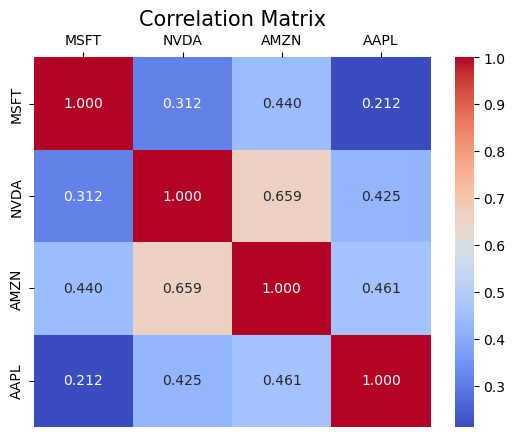

In [5]:
if __name__=="__main__":
    
    tickers = ["MSFT","NVDA","AMZN","AAPL"]     #choose portfolio of stocks
    weights = np.array([1/len(tickers) for i in range(len(tickers))])
    confidence_level= 0.95                      #set confidence level for VaR
    
    start =pd.Timestamp(2024,2,1)
    stop = pd.Timestamp(2025,2,1)
    
    data = yf.download(tickers, start, stop)    #download data
    close_prices = data["Close"]
    S0i = close_prices.iloc[0].to_numpy()       #initial stock price
    returns = close_prices.pct_change().dropna()
    portfolio_returns = np.dot(returns,weights) #portfolio of weighted stocks
    C = returns.corr().values                   #correlation matrix
    n_runs = 10000                              #number of Monte Carlo runs

    VaR_Merton,VaR_BS = VaR_Monte_Carlo_P(C,returns,S0i,n_runs,confidence_level) 
    print(f"Portfolio VaR at {confidence_level*100}%(Merton Jump-Diffusion): {100*VaR_Merton:.2f}%")
    print(f"Portfolio VaR at {confidence_level*100}%(Black-Scholes): {100*VaR_BS:.2f}%")
    
    plot_returns(portfolio_returns, confidence_level, VaR_Merton, VaR_BS)
    plot_corr_mat(C, tickers)

## References

<a id="ref1"></a>[1] Burgess, Nicholas, "<a href="https://ssrn.com/abstract=4066115">*Correlated Monte Carlo Simulation using Cholesky Decomposition*</a>" (March 25, 2022). Available at SSRN: https://ssrn.com/abstract=4066115

<a id="ref2"></a>[2] Martin, M. "<a href="https://ora.ox.ac.uk/objects/uuid:a169f320-4ef9-49a0-9297-1cf0bc4dce23">*A Two-Asset Jump Diffusion
Model with Correlation*</a>"(Thesis) 2007.